<a href="https://colab.research.google.com/github/lleviraz/bert-gender-bias/blob/main/bert_gender_stress_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text based Stress Detection on “Dreaddit” Dataset - Part 2 - Innovation - Gender Bias Detection...**
Advanced ML Course Final Project


---
Students: Eli Terris-Assa and Liad Levi-Raz




# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PATH='/content/drive/MyDrive/2022/S2/3603_Advanced_MachineLearning/notebooks/final_proj/'

SEED=777

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Setup notes** 

- make sure to restart the notebook after installing wefe - otherwise you may get the following error: "TypeError: load() missing 1 required positional argument: 'Loader'"

- If you see the message "ImportError: cannot import name 'exception_to_str' from 'matplotlib.cbook'" it is normal after first installation - restart the NB and run the cells again.

In [2]:
!pip install transformers simpletransformers gensim transformers-interpret -q
!pip install --upgrade responsibly wefe pyyaml==5.4.1 -q
!pip install allennlp==0.9.0 spacy==2.1.4 overrides==3.1.0 -q

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#setup for wefe and responsibly.ai
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

def print_message():
  msg =   print(100*'=')
  print('This is normal on the first time WEFE is installed in Colab - Please restart the kernel an run again')
  print(100*'=')
  assert(1==0)

try:
  # from wefe import datasets
  from wefe.query import Query
  from wefe.metrics import WEAT
  # from wefe.datasets import load_weat
  from wefe.utils import plot_queries_results
  from wefe.word_embedding_model import WordEmbeddingModel
  
  import responsibly
  import matplotlib.pylab as plt
  from responsibly.we import load_w2v_small
  from responsibly.we import GenderBiasWE, most_similar


except TypeError:
  print_message()
except AttributeError:
  print_message()


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [5]:
#setup for bias score utils
#warmup of spacy
from allennlp.common.util import get_spacy_model
try:
  get_spacy_model("en", pos_tags=False, parse=True, ner=False)
except:
  pass

!git clone https://github.com/lleviraz/contextual_embedding_bias_measure.git

import sys
sys.path.append("contextual_embedding_bias_measure/lib")

from typing import *
from pathlib import Path
from itertools import product
from collections import defaultdict
from scipy.stats import ttest_ind, ranksums
from mlxtend.evaluate import permutation_test
from pytorch_pretrained_bert import BertConfig, BertForMaskedLM
from bias_utils import BiasUtils
from bert_utils import Config, BertPreprocessor

fatal: destination path 'contextual_embedding_bias_measure' already exists and is not an empty directory.


In [6]:
#other imports and setup
import os
import torch
import logging
import numpy as np
import pandas as pd
from numpy import std
import seaborn as sns
from numpy import mean
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

#preprocessing
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler

#sklearn related
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Perceptron,LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report,f1_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

#NLP related
import transformers
from gensim import downloader
from simpletransformers.classification import ClassificationModel, ClassificationArgs

import gc
import time
#Transformers Interpret
from wordcloud import WordCloud
from nltk.corpus import stopwords
from transformers_interpret import SequenceClassificationExplainer

#Gensim
import gensim.downloader as api
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import common_texts

In [7]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Load dataset

In [8]:
# a word2vec-300 embedding vocabulary file prepared once (downloading w2v-300 is 1.6GB)
VOCAB_FILE='dreaddit_vocab.txt'

In [9]:
!mkdir -p data 
!cp -n {DRIVE_PATH}/dataset/dreaddit_data.zip .
!cp -n {DRIVE_PATH}/{VOCAB_FILE} .
!unzip -n dreaddit_data.zip -d data

Archive:  dreaddit_data.zip


In [10]:
df_train = pd.read_csv("data/dreaddit-train.csv")
df_test = pd.read_csv("data/dreaddit-test.csv")

df_train.head(2)

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.125,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857


In [11]:
df_test.head(2)

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.8,1.514981e+09,22,-1.238793,...,1.0,1.200,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.0,1.493348e+09,5,7.684583,...,1.4,1.125,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909


In [12]:
# with pd.set_option("max_colwidth", 1000):
df_train[['id','text','label']].head(2)

,id,text,label
0,33181,"He said he had not felt that way before, sugge...",1
1,2606,"Hey there r/assistance, Not sure if this is th...",0


# EDA

In [13]:
print('Train instances',df_train.shape)
print('Test instances',df_test.shape)

Train instances (2838, 116)
Test instances (715, 116)


In [14]:
print('Categorical columns, Train:',df_train.select_dtypes(include=['object']).columns.tolist(),
      'Test:',df_test.select_dtypes(include=['object']).columns.tolist())


Categorical columns, Train: ['subreddit', 'post_id', 'sentence_range', 'text'] Test: ['subreddit', 'post_id', 'sentence_range', 'text']


## Classes balance
- Label ---> 1 (Stress)
- Label ---> 0 (Not stressed)

The paper reported that 52.3% posts are labelled as stressed which matches our findings below

In [15]:
stress_class2name = {0:'NotStressed',1:'Stressed'}
stress_name2class = {v: k for k, v in stress_class2name.items()}
gender_class2name = {0:'Male',1:'Female'}
gender_name2class = {v: k for k, v in gender_class2name.items()}
stress_name2class,gender_name2class

({'NotStressed': 0, 'Stressed': 1}, {'Male': 0, 'Female': 1})

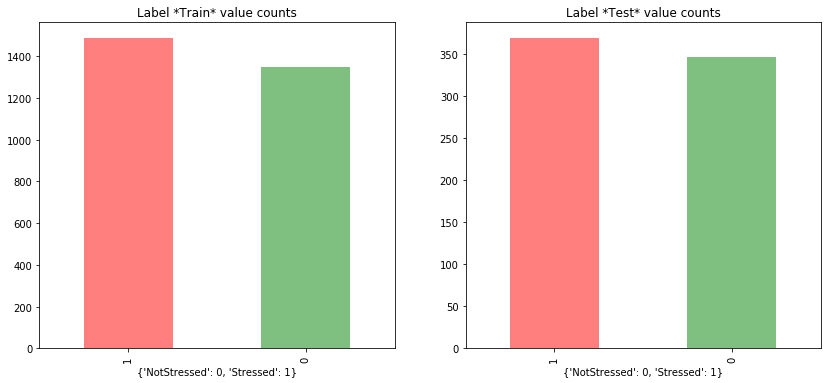

In [16]:
f,axs = plt.subplots(1,2,figsize=(14,6))
df_train.label.value_counts().plot.bar(ax=axs[0],color=['r','g'],alpha=0.5)
df_test.label.value_counts().plot.bar(ax=axs[1],color=['r','g'],alpha=0.5)
axs[0].set_title('Label *Train* value counts')
axs[1].set_title('Label *Test* value counts')
axs[0].set_xlabel(stress_name2class)
axs[1].set_xlabel(stress_name2class)
plt.show()

In [17]:
trn_cnts = df_train.label.value_counts()
tst_cnts = df_test.label.value_counts()
'{:.1f}% posts are labelled as stressed'.format((trn_cnts[1] + tst_cnts[1]) / (trn_cnts[0] + tst_cnts[0] + trn_cnts[1] + tst_cnts[1])*100)


'52.3% posts are labelled as stressed'

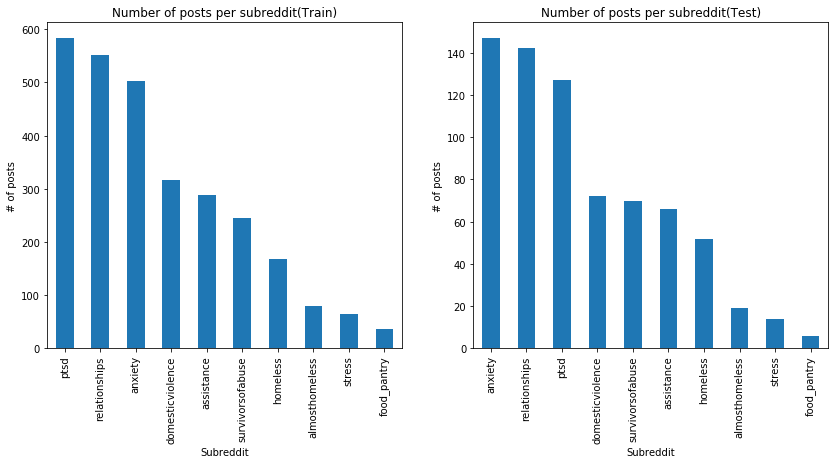

In [18]:
f,axs = plt.subplots(1,2,figsize=(14,6))
df_train.subreddit.value_counts().plot.bar(ax=axs[0])
df_test.subreddit.value_counts().plot.bar(ax=axs[1])
axs[0].set_title('Number of posts per subreddit(Train)')
axs[1].set_title('Number of posts per subreddit(Test)')
axs[0].set_xlabel('Subreddit')
axs[1].set_xlabel('Subreddit')
axs[0].set_ylabel('# of posts')
axs[1].set_ylabel('# of posts')
plt.show()

## Prior Gender ratio

There seems to be a ratio of 1:4 (25% texts are cetegorized as being posted by females) of texts posted by females based on the dataset "lex_liwc_female" aמd "lex_liwc_male" features.
We noticed, however, that in online publications discussing the reported demographic statistics in Reddit posts, the ratio is closer to 2:3 (~40% women)

- "Female" = 1
- "Male" = 0

In [19]:
from numpy.random import choice
#pick female or male by the prior assumption of .40/.60
choice(2,10,p=[0.4,0.6])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
df_gender_trn = df_train.copy()
df_gender_tst = df_test.copy()

In [21]:
df_gender_trn['Female'] = np.where(df_gender_trn.lex_liwc_female>df_gender_trn.lex_liwc_male,1,0)
df_gender_tst['Female'] = np.where(df_gender_tst.lex_liwc_female>df_gender_tst.lex_liwc_male,1,0)

In [22]:
print('Trn:\n',df_gender_trn.Female.value_counts(),'\nTst:\n',df_gender_tst.Female.value_counts())

Trn:
 0    2127
1     711
Name: Female, dtype: int64 
Tst:
 0    533
1    182
Name: Female, dtype: int64


### Ratio of male or female originated texts based on the 'LEX' columns

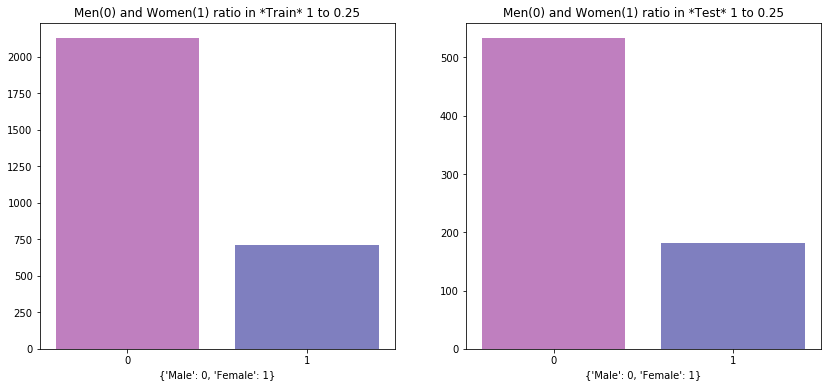

In [23]:
f,axs = plt.subplots(1,2,figsize=(14,6))#,sharey=True)
trn=df_gender_trn.Female.value_counts()
male_trn = trn[0]
female_trn = trn[1]
female_pct_trn = female_trn/(male_trn+female_trn)
tst=df_gender_tst.Female.value_counts()
male_tst = tst[0]
female_tst = tst[1]
female_pct_tst = female_tst/(male_tst+female_tst)

axs[0].bar([0,1],[male_trn,female_trn],color=['purple','navy'],alpha=0.5)
axs[1].bar([0,1],[male_tst,female_tst],color=['purple','navy'],alpha=0.5)
axs[0].set_title('Men(0) and Women(1) ratio in *Train* 1 to {:.2f}'.format(female_pct_trn))
axs[1].set_title('Men(0) and Women(1) ratio in *Test* 1 to {:.2f}'.format(female_pct_tst))
axs[0].set_xlabel(gender_name2class)
axs[1].set_xlabel(gender_name2class)
axs[0].set_xticks([0,1])
axs[1].set_xticks([0,1])
plt.show()

## Posts Text lengths

The paper reported the average length around 100 which matches the average of 106 we see here (for labelled instances only)

In [24]:
# find the maximum snetence length after tokenizer
bert_tok = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

def find_max_lengths(tok,texts,percent,caption):
  max_sent_length = 0
  max_sent_length_list = []

  for sent in tqdm(texts):
      tokens= tok.tokenize(sent)
      ids = tok.convert_tokens_to_ids(tokens)
      input_len = len(tokens)
      input_len2 = len(ids)
      assert(input_len==input_len2)
      max_sent_length_list.append(input_len)

  max_sent_length = int(np.percentile(max_sent_length_list,percent))+1
  avg_sent_length = int(np.mean(max_sent_length_list))+1
  print(caption + ': {}th percentile of input length<={}'.format(percent,max_sent_length))
  print(caption + ': Average sentence length={}'.format(avg_sent_length))
  return max_sent_length,max_sent_length_list

# After trying with large values 500, 99.9=327 and others, we finally decided to
#take a "max len" of more or less +/-(2) standards devitations from the mean length
PERCENT=99.9 #60. best so far
max_length,trn_len_list = find_max_lengths(bert_tok,df_train['text'].values,PERCENT,caption='Train')
print ("Train Max input length after tokenization {}".format(max_length))


  0%|          | 0/2838 [00:00<?, ?it/s]

Train: 99.9th percentile of input length<=333
Train: Average sentence length=106
Train Max input length after tokenization 333


In [25]:
_,tst_len_list = find_max_lengths(bert_tok,df_test['text'].values,PERCENT,caption='Test')

  0%|          | 0/715 [00:00<?, ?it/s]

Test: 99.9th percentile of input length<=282
Test: Average sentence length=105


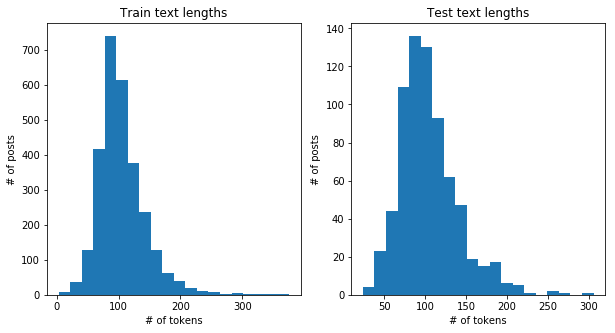

In [26]:
f,ax = plt.subplots(1,2,figsize=(10,5))
plt.title('Posts text lengths (# of token)')
ax[0].hist(trn_len_list,bins=20)
ax[0].set_title('Train text lengths')
ax[0].set_xlabel('# of tokens')
ax[0].set_ylabel('# of posts')
ax[1].hist(tst_len_list,bins=20)
ax[1].set_title('Test text lengths')
ax[1].set_xlabel('# of tokens')
ax[1].set_ylabel('# of posts')
plt.show()

In [27]:
#adding feature of text length 
df_train['text_length']=trn_len_list
df_test['text_length']=tst_len_list

## Feature Selection 

- Taking only features with a high confidence (4/5 human annotators agreement)
- Analyzing the correlation of features to the label, $Pearson \ge 0.4$ 

In [28]:
df_train = df_train.drop(['post_id', 'sentence_range', 'id'], axis = 1)
df_test = df_test.drop(['post_id', 'sentence_range', 'id'], axis = 1)

In [29]:
#Taking only instances with 80% agreement or more (confidence >=0.8)
print(len(df_train),len(df_test))
df_train = df_train[df_train['confidence']>=0.8]
df_test = df_test[df_test['confidence']>=0.8]
print(len(df_train),len(df_test))

2838 715
1852 445


In [30]:
df = pd.concat([df_train,df_test],axis=0,ignore_index=True)
df = df.sample(frac = 1).reset_index(drop = True)
df.head(3)

,subreddit,text,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,...,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,text_length
0,anxiety,I was having a mild form of attack during the ...,0,1.0,1.538790e+09,1,4.798261,65,2.01,22.08,...,1.1818,1.0,1.70076,1.37544,1.82583,1.0,0,5.825435,0.069841,87
1,anxiety,I constantly face so much anxiety in school. I...,1,1.0,1.535050e+09,4,4.976937,69,13.05,2.98,...,1.1429,1.0,1.78667,1.56271,1.82688,1.0,2,5.963243,-0.214815,93
2,ptsd,(TW sexual abuse mentions) When I was 14 I was...,1,1.0,1.536279e+09,18,10.790848,151,14.85,7.27,...,1.1429,1.0,1.70239,1.56444,1.92623,1.0,6,9.870230,0.051333,185


In [31]:
#One hot encoding for the 'subreddit' column
le = LabelEncoder()
df['subreddit'] = le.fit_transform(df['subreddit'])


In [32]:
df.head(2)

,subreddit,text,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,...,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,text_length
0,1,I was having a mild form of attack during the ...,0,1.0,1.538790e+09,1,4.798261,65,2.01,22.08,...,1.1818,1.0,1.70076,1.37544,1.82583,1.0,0,5.825435,0.069841,87
1,1,I constantly face so much anxiety in school. I...,1,1.0,1.535050e+09,4,4.976937,69,13.05,2.98,...,1.1429,1.0,1.78667,1.56271,1.82688,1.0,2,5.963243,-0.214815,93


## Paper reported best score when:
- Confidence >=0.8 (4/5) 
- Correlation >= 0.4

## Feature Selection

In the paper they reported the best results with only the features that have  **$\ge 0.40$** Pearson correlation to the label

In [33]:
most_correlated = df.corr().abs()['label'].sort_values(ascending = False)
#Taking only highest correlated features (paper's report |r|>=0.4)
most_correlated = most_correlated[:6]
most_correlated

label              1.000000
lex_liwc_Tone      0.567659
lex_liwc_Clout     0.506182
lex_liwc_negemo    0.506085
lex_liwc_i         0.491079
sentiment          0.390355
Name: label, dtype: float64

# Preprocessing

2 Tokenizers compared:
BertTokenizer and Bert using  Word2Vec vocabulary (Paper used it for best model)

In [34]:
def clear_cache():
  import gc
  gc.collect()

In [35]:
# Generate embedding vocabulary and save as local file 
def make_vocab_from_wv(wv, folder=None, special_tokens=None):

    words = wv.index2word
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words
                
    with open(os.path.join(folder, VOCAB_FILE), 'w') as f:
        for word in words:
            f.write(f'{word}\n') 

# run the function and make vocab on training data
if(os.path.exists(VOCAB_FILE)):
  print('Using local vocab file:',VOCAB_FILE)
else:
  # Download and load the word2vec embedding - based on the paper best model
  # This was done once and saved vocab in '
  word2vec = downloader.load('word2vec-google-news-300')
  make_vocab_from_wv(word2vec, 
                   './', 
                   special_tokens=['[PAD]', '[UNK]'])

Using local vocab file: dreaddit_vocab.txt


In [36]:
clear_cache()
w2v_tok = transformers.BertTokenizer(VOCAB_FILE)

In [37]:
#creating a function
def tokenize(tokenizer, texts):
    features = []
    for txt in tqdm(texts, desc = 'Tokenizing texts...'):
        tokens = tokenizer.tokenize(txt)
        ids = tokenizer.convert_tokens_to_ids(tokens)
        features.append(ids)
    return features

In [38]:
#convert all column names to str
df.columns = df.columns.astype(str)

# Part 1 - Loading the Bert for Stress Classifier (from Part1)

Full implementation and reproduction of the paper results can be found in [Part 1 NB](https://drive.google.com/file/d/1cBy5xzohSD7IiPXhFgkbwoBuk2X3Qeo9/view?usp=sharing)

## Bert for stress classification

Loading the pretrained Bert stress classifier model from part 1 - in inference mode - this is the same as was done for Part 1, however now the model is loaded in order to measure the bias embedded in it

In [39]:
def clean_old_cache(path='outputs'):
  !rm -rf cache_dir
  !rm -rf {path}
  !rm -rf runs

In [40]:
# Train or Inference mode
TRAINED_MODEL='bert_dreaddit_stress_model_part2.zip'
!cp -nf {DRIVE_PATH}/last_model/{TRAINED_MODEL} .
INFERENCE_MODE = os.path.isfile(TRAINED_MODEL)

In [41]:
STRESS_MODEL_MODEL_TYPE="bert-base-uncased"

logging.basicConfig(level=logging.ERROR)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.ERROR)

if(INFERENCE_MODE):
  # clean_old_cache()
  print('Inference mode, loading best model...')
  !unzip -q -n {TRAINED_MODEL}
  # Create a ClassificationModel
  model = ClassificationModel(
      "bert", "outputs/best_model",
      tokenizer_type=w2v_tok,
      # "bert", "bert-base-uncased", #f1=80 Paper's BEST
      # "roberta", "outputs/best_model", #f1=80 BEST
      use_cuda=torch.cuda.is_available()
  )
  print('Best model loaded.')
else:
  print('Training mode')
  # Optional model configuration
  model_args = ClassificationArgs(overwrite_output_dir = True,
                                  fp16=True,
                                  use_early_stopping = True,
                                  # max_seq_length=max_length,
                                  no_save = False,
                                  save_best_model=True,
                                  evaluate_during_training = True,
                                  evaluate_during_training_verbose=False,
                                  evaluate_during_training_silent=True,
                                  #paper's best params
                                  # num_train_epochs=3,
                                  # train_batch_size=128,
                                  # learning_rate=0.0005,
  )

  # Create a ClassificationModel
  model = ClassificationModel(
      # "roberta", "roberta-base", #f1=80 BEST on full
      "bert", STRESS_MODEL_MODEL_TYPE,tokenizer_type=w2v_tok,#f1=84 #Paper's best
      # "bert", "bert-base-cased",#f1=79
      # "roberta", "roberta-large", #f1=77
      # "distilbert", "bert-base-uncased", #f1=71
      # "albert","bert-base-uncased", #bad
      # "electra", "bert-base-uncased", #bad...
      args=model_args,
      use_cuda=torch.cuda.is_available(),
  )

  # Train the model
  model.train_model(df_train[['text','label']],eval_df=df_test[['text','label']])

Inference mode, loading best model...
Best model loaded.


In [42]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(df_test[['text','label']])

  0%|          | 0/445 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/56 [00:00<?, ?it/s]

In [43]:
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    

In [44]:
#TODO delete
# y_true_trn = df_train['label'].values
# print('Train classification report')
# y_pred_trn, _ = model.predict(list(df_train['text']))


In [45]:
#TODO delete
# print(classification_report(y_true_trn, y_pred_trn))

In [46]:
#TODO delete
# Showing Confusion Matrix for ST Bert model
# plot_cm(y_true_trn,y_pred_trn, 'Bert Confusion matrix Train', figsize=(7,7))

In [47]:
y_true_tst = df_test['label'].values
y_pred_tst, _ = model.predict(list(df_test['text']))

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

In [48]:
#TODO delete
# print(classification_report(y_true_tst, y_pred_tst))
f1_bert = f1_score(y_true_tst, y_pred_tst,average='weighted')

In [49]:
#TODO delete
# Showing Confusion Matrix for ST Bert model
# plot_cm(y_true_tst,y_pred_tst, 'Bert Confusion matrix Test', figsize=(7,7))

In [50]:
all_models = ['BERT-stress classifier'] #+ names
all_results = [f1_bert] #+ [np.mean(r) for r in results]

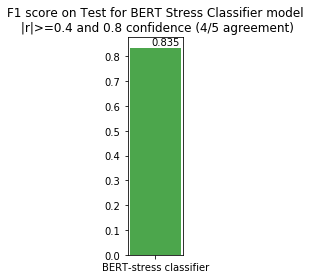

In [51]:
# plot model performance
f,ax = plt.subplots(1,1,figsize=(1,4))
cmap = ['green']
plt.bar(all_models,all_results,color=cmap,alpha=0.7)
for j,p in enumerate(ax.patches):
  ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x()/7, p.get_height() * 1.01))

plt.title('F1 score on Test for BERT Stress Classifier model\n |r|>=0.4 and 0.8 confidence (4/5 agreement)')
plt.show()


# Part 2 - Gender Bias Detection in Contextualized Word Embedding

In this part our goal is to **detect** and **measure** gender bias in our Stress Classifier latent space.

1. As a first step we are predicting the gender of every post, based on the text, using a pretrained "bert" model, and using the Dreaddit gender related features as ground truth ("lex_liwc_male" and "lex_liwc_female")

2. "Fun Fact" - Based on internet resources, the majority of Reddit users are males (61%)"(e.g. at: https://thrivemyway.com/reddit-statistics/ or [demographics in Reddit](https://medium.com/@sm_app_intel/the-user-demographics-of-reddit-the-official-app-7e2e18b1e0e1#:~:text=Gender%3A%2059%25%20of%20the%20Reddit,have%20a%20high%20school%20degree).

3. In our EDA, based on the "lex_liwc_male" and "lex_liwc_female", we see only 26% females and not 40%

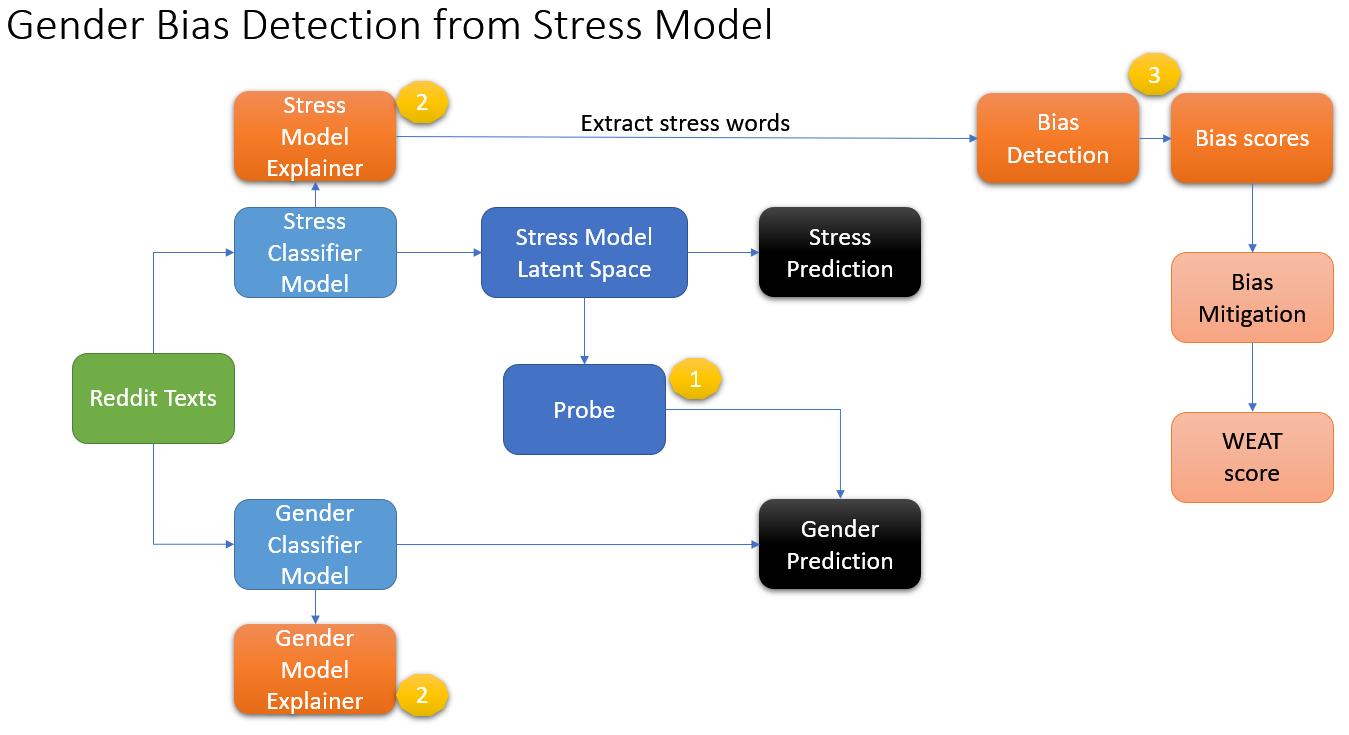


1. Detecting gender bias in Bert Stress Classifier latent space
2. Stress Model Explainability - extracting the most exlaining words
3. Measuring the gender bias 

In [52]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#Adding custom stop words to be ignored by the models and explainer
custom_stop_words = ['CLS','SEP','##il','##gg','would','could','##bag','like', \
                     'prople','know','one','##er','s','year','years','time', \
                     'day','month','months','week','ca','also','got','get','since', \
                     'place','way','go','really','want','u','thing']


stop_words = stopwords.words('english')
stop_words.extend(custom_stop_words)

def clean_text(text):  
  word_tokens = word_tokenize(text)
  filtered_sentence = [word.lower() for word in word_tokens if word.isalpha()]
  filtered_sentence = [w for w in filtered_sentence if not w.lower() in stop_words]
  filtered_sentence = [w for w in filtered_sentence if not w.lower().startswith('##')]
  return ' '.join(filtered_sentence)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
df_gender_trn['clean_text'] = [clean_text(txt) for txt in tqdm(df_gender_trn['text'].values)]
df_gender_tst['clean_text'] = [clean_text(txt) for txt in tqdm(df_gender_tst['text'].values)]
df_gender_trn[['text','clean_text']].head(3)

  0%|          | 0/2838 [00:00<?, ?it/s]

  0%|          | 0/715 [00:00<?, ?it/s]

,text,clean_text
0,"He said he had not felt that way before, sugge...",said felt suggeted rest trigger ahead youi hyp...
1,"Hey there r/assistance, Not sure if this is th...",hey sure right post goes currently student int...
2,My mom then hit me with the newspaper and it s...,mom hit newspaper shocked knows play hitting s...


## Bert Gender Classifier

In [54]:
# Train or Inference mode
P2_TRAINED_MODEL='bert_dreaddit_gender_model_part2.zip'
!cp -nf {DRIVE_PATH}/last_model/{P2_TRAINED_MODEL} .
P2_INFERENCE_MODE = os.path.isfile(P2_TRAINED_MODEL)

In [55]:
OUT2_DIR='part2_outputs/'

logging.basicConfig(level=logging.ERROR)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.ERROR)

if(P2_INFERENCE_MODE):
  # clean_old_cache()
  print('Inference mode, loading best model...')
  !unzip -q -n {P2_TRAINED_MODEL}
  # Create a ClassificationModel
  model2 = ClassificationModel(
      "bert", OUT2_DIR,
      tokenizer_type=w2v_tok,
      # "bert", "bert-base-uncased", #f1=80 Paper's BEST
      # "roberta", "outputs/best_model", #f1=80 BEST
      use_cuda=torch.cuda.is_available()
  )
  print('Best model loaded.')
else:
  print('Training mode')
  # Optional model configuration
  model_args = ClassificationArgs(
                                  # num_train_epochs=3,
                                  output_dir=OUT2_DIR,
                                  overwrite_output_dir = True,
                                  fp16=True,
                                  use_early_stopping = True,
                                  no_save = False,
                                  save_best_model=True,
  )

  # Create a ClassificationModel
  model2 = ClassificationModel(
      "bert", "Cameron/BERT-rtgender-opgender-annotations",#f1=0.96
      tokenizer_type=w2v_tok,
      # "bert","mlkorra/obgv-gender-bert-hi-en",#f1=0.73
      # "roberta","Maha/OGBV-gender-twtrobertabase-en-founta_final", #f1=0.71
      # "electra","monologg/koelectra-base-v3-gender-bias", #f1=0.77
      # "albert","Maha/OGBV-gender-indicbert-ta-eacl_finals", #f1=0.68
      # "distilbert","malcolm/REA_GenderIdentification_v1", #f1=0.66
      # "bert", "Abderrahim2/bert-finetuned-gender_classification", #doesnt work
      # "bert","mlkorra/OGBV-gender-bert-hi-en", #bad
      # "bert","Cameron/BERT-mdgender-convai-binary", #bad
      args=model_args,
      use_cuda=torch.cuda.is_available()
  )

  # Fine tune the model with our additional texts
  model2.train_model(df_gender_trn[['text','Female']])
  # model2.train_model(df_gender_trn[['clean_text','Female']])

Inference mode, loading best model...
Best model loaded.


In [56]:
BACKUP=False
if(BACKUP):
  !zip {P2_TRAINED_MODEL} {OUT2_DIR}/*.*
  !cp -nf {P2_TRAINED_MODEL} {DRIVE_PATH}/last_model/

In [57]:
# Evaluate the model
result, model_outputs, wrong_predictions = model2.eval_model(df_gender_tst[['text','Female']])
# result, model_outputs, wrong_predictions = model2.eval_model(df_gender_tst[['clean_text','Female']])
# result

  0%|          | 0/715 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/90 [00:00<?, ?it/s]

In [58]:
y_true_trn = df_gender_trn['Female'].values
# print('Train classification report')
y_pred_trn, _ = model2.predict(list(df_gender_trn['text']))
# # y_pred_trn, _ = model2.predict(list(df_gender_trn['clean_text']))
# print(classification_report(y_true_trn, y_pred_trn))

  0%|          | 0/2838 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

In [59]:
y_true_tst = df_gender_tst['Female'].values
print('Test classification report')
y_pred_tst, _ = model2.predict(list(df_gender_tst['text']))
# y_pred_tst, _ = model2.predict(list(df_gender_tst['clean_text']))

print(classification_report(y_true_tst, y_pred_tst))

Test classification report


  0%|          | 0/715 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       533
           1       0.93      0.93      0.93       182

    accuracy                           0.96       715
   macro avg       0.95      0.95      0.95       715
weighted avg       0.96      0.96      0.96       715



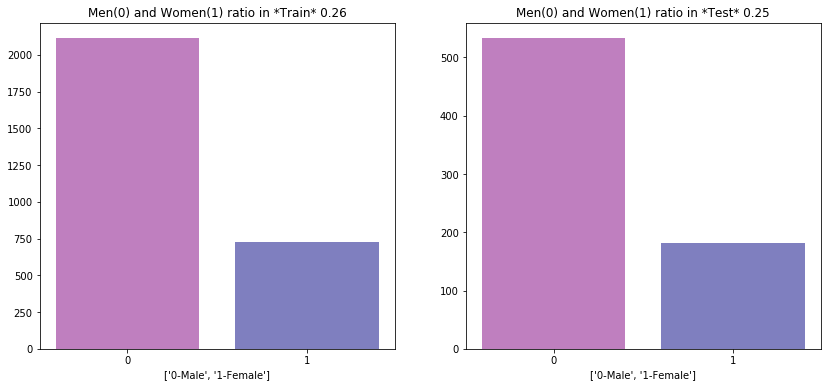

In [60]:
f,axs = plt.subplots(1,2,figsize=(14,6))
trn=pd.DataFrame(y_pred_trn).value_counts()
tst=pd.DataFrame(y_pred_tst).value_counts()
male_trn = trn[0]
female_trn = trn[1]
female_pct_trn = female_trn/(male_trn+female_trn)
male_tst = tst[0]
female_tst = tst[1]
female_pct_tst = female_tst/(male_tst+female_tst)

axs[0].bar([0,1],[male_trn,female_trn],color=['purple','navy'],alpha=0.5)
axs[1].bar([0,1],[male_tst,female_tst],color=['purple','navy'],alpha=0.5)
axs[0].set_title('Men(0) and Women(1) ratio in *Train* {:.2f}'.format(female_pct_trn))
axs[1].set_title('Men(0) and Women(1) ratio in *Test* {:.2f}'.format(female_pct_tst))
axs[0].set_xlabel(['0-Male','1-Female'])
axs[1].set_xlabel(['0-Male','1-Female'])
axs[0].set_xticks([0,1])
axs[1].set_xticks([0,1])
plt.show()

In [61]:
df_gender_trn['Female_pred'] = y_pred_trn
df_gender_tst['Female_pred'] = y_pred_tst

Trying to see if we have stress prediction gender bias

Train - Precentage of texts labelled as stressed and labelled as female:0.52
Test - Precentage of texts labelled as stressed and labelled as female:0.52


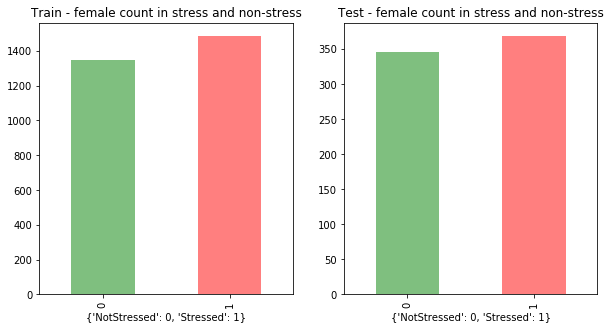

In [62]:
f,axs = plt.subplots(1,2,figsize=(10,5))
female_in_stress = df_gender_trn.groupby('label')['Female'].count()
female_in_stress.plot.bar(title='Train - female count in stress and non-stress',ax=axs[0],color=['g','r'],alpha=0.5)
print('Train - Precentage of texts labelled as stressed and labelled as female:{:.2f}'.format(female_in_stress[1]/(female_in_stress[0]+female_in_stress[1])))

female_in_stress_tst = df_gender_tst.groupby('label')['Female'].count()
female_in_stress_tst.plot.bar(title='Test - female count in stress and non-stress',ax=axs[1],color=['g','r'],alpha=0.5)
tst_ratio = female_in_stress_tst[1]/(female_in_stress_tst[0]+female_in_stress_tst[1])
print('Test - Precentage of texts labelled as stressed and labelled as female:{:.2f}'.format(tst_ratio))

axs[0].set_xlabel(stress_name2class)
axs[1].set_xlabel(stress_name2class)
plt.show()

# Transformer Models Explainer
A great tool for showing which words were impacting on the classification of a model

https://github.com/cdpierse/transformers-interpret


In [63]:
stress_cls_explainer = SequenceClassificationExplainer(
    model.model,
    model.tokenizer)
gender_cls_explainer = SequenceClassificationExplainer(
    model2.model,
    model2.tokenizer)


In [64]:
# import random
# j = random.randint(0,len(df_gender_tst))
j = 706
for txt in tqdm(df_gender_tst['clean_text'].values[j:j+1]):
  word_emb1 = gender_cls_explainer(txt)
  word_emb2 = stress_cls_explainer(txt)

  0%|          | 0/1 [00:00<?, ?it/s]

Gender model:
- "Female" = 1
- "Male" = 0

In [65]:
gender_true_class=gender_class2name[int(gender_cls_explainer.predicted_class_index)]
print('Class:{} ({})'.format(gender_cls_explainer.predicted_class_name,gender_true_class))
sorted(word_emb1, key=lambda x: x[1], reverse=True)[:10]

Class:LABEL_1 (Female)


[('girl', 0.861389644758821),
 ('##bag', 0.1214643807454379),
 ('abusive', 0.11380596072396433),
 ('friends', 0.047968315433165),
 ('however', 0.04404708460764924),
 ('horrific', 0.04218048405092322),
 ('least', 0.038355072627652004),
 ('second', 0.02138722355379906),
 ('course', 0.01674182639082488),
 ('daughter', 0.015910753871547667)]

In [66]:
gender_cls_explainer.visualize(true_class=gender_true_class)

Stress model:
- "Stressed" = 1
- "Not stressed" = 0

In [67]:
stress_true_class=stress_class2name[int(stress_cls_explainer.predicted_class_index)]
print('Class:{} ({})'.format(stress_cls_explainer.predicted_class_name,stress_true_class))
sorted(word_emb2, key=lambda x: x[1], reverse=True)[:10]

Class:LABEL_1 (Stressed)


[('drunken', 0.4119716577029599),
 ('horrific', 0.31275277700393406),
 ('abusive', 0.2967857251261501),
 ('pleaded', 0.19094239896558343),
 ('shit', 0.1532175388198624),
 ('begged', 0.13145968300239713),
 ('friends', 0.13012316809450133),
 ('find', 0.1266217232614313),
 ('worse', 0.12378379991392349),
 ('girl', 0.10323188711905432)]

In [68]:
stress_cls_explainer.visualize(true_class=stress_true_class)

Collecting the "k" most & "least" important words as given by the explainer in every text in 8 sets (Train Gender, Test Gender, Train Stress and Test stress - for each "most" and "least" topk words)

In [69]:
# !rm -f trn_* && rm -f tst_*;

In [70]:
def get_words_list(l):
  return [w[0] for w in l if not w[0].startswith('##')]

def find_words(ddf,k=5):
  cls0_top_gender_words=[]
  cls0_top_stress_words=[]
  cls1_top_gender_words=[]
  cls1_top_stress_words=[]
  for txt in tqdm(ddf['clean_text'].values):
    gc.collect()
    cls0_word_emb1 = gender_cls_explainer(txt,0)
    cls1_word_emb1 = gender_cls_explainer(txt,1)
    cls0_top_words1 = sorted(cls0_word_emb1, key=lambda x: x[1], reverse=True)[:k]
    cls1_top_words1 = sorted(cls1_word_emb1, key=lambda x: x[1], reverse=True)[:k]
    
    cls0_word_emb2 = stress_cls_explainer(txt,0)
    cls1_word_emb2 = stress_cls_explainer(txt,1)
    cls0_top_words2 = sorted(cls0_word_emb2, key=lambda x: x[1], reverse=True)[:k]
    cls1_top_words2 = sorted(cls1_word_emb2, key=lambda x: x[1], reverse=True)[:k]

    cls0_top_gender_words.extend(get_words_list(cls0_top_words1))
    cls1_top_gender_words.extend(get_words_list(cls1_top_words1))
    
    cls0_top_stress_words.extend(get_words_list(cls0_top_words2))
    cls1_top_stress_words.extend(get_words_list(cls1_top_words2))

  return cls0_top_gender_words,cls0_top_stress_words,cls1_top_gender_words,cls1_top_stress_words

In [71]:
%%time
!cp -nf {DRIVE_PATH}/cache/cls0_top*.csv .
!cp -nf {DRIVE_PATH}/cache/cls1_top*.csv .
time.sleep(5)

#load csvs from files and skip long run of extracting "most explaining words"...
if(os.path.exists('cls0_top_gender_words_trn.csv')):
  print('Loading most explaining words from cache...')
  cls0_top_gender_words_trn=list([v.item() for v in pd.read_csv('cls0_top_gender_words_trn.csv',dtype=str).values])
  cls0_top_stress_words_trn=list([v.item() for v in pd.read_csv('cls0_top_stress_words_trn.csv',dtype=str).values])
  cls0_top_gender_words_tst=list([v.item() for v in pd.read_csv('cls0_top_gender_words_tst.csv',dtype=str).values])
  cls0_top_stress_words_tst=list([v.item() for v in pd.read_csv('cls0_top_stress_words_tst.csv',dtype=str).values])
  cls1_top_gender_words_trn=list([v.item() for v in pd.read_csv('cls1_top_gender_words_trn.csv',dtype=str).values])
  cls1_top_stress_words_trn=list([v.item() for v in pd.read_csv('cls1_top_stress_words_trn.csv',dtype=str).values])
  cls1_top_gender_words_tst=list([v.item() for v in pd.read_csv('cls1_top_gender_words_tst.csv',dtype=str).values])
  cls1_top_stress_words_tst=list([v.item() for v in pd.read_csv('cls1_top_stress_words_tst.csv',dtype=str).values])
else:
  print('Finding most explaining words...')
  cls0_top_gender_words_trn,cls0_top_stress_words_trn,cls1_top_gender_words_trn,cls1_top_stress_words_trn = find_words(df_gender_trn)  
  cls0_top_gender_words_tst,cls0_top_stress_words_tst,cls1_top_gender_words_tst,cls1_top_stress_words_tst = find_words(df_gender_tst)
  #Backup to drive
  nms = ['cls0_top_gender_words_trn','cls0_top_stress_words_trn','cls0_top_gender_words_tst','cls0_top_stress_words_tst','cls1_top_gender_words_trn','cls1_top_stress_words_trn','cls1_top_gender_words_tst','cls1_top_stress_words_tst']
  for i,f in enumerate([cls0_top_gender_words_trn,cls0_top_stress_words_trn,cls0_top_gender_words_tst,cls0_top_stress_words_tst,cls1_top_gender_words_trn,cls1_top_stress_words_trn,cls1_top_gender_words_tst,cls1_top_stress_words_tst]):
    pd.DataFrame(list(f)).to_csv(nms[i]+'.csv',header=False,index=False)
  !cp cls0_top*.csv {DRIVE_PATH}/cache/
  !cp cls1_top*.csv {DRIVE_PATH}/cache/

Loading most explaining words from cache...
CPU times: user 102 ms, sys: 138 ms, total: 240 ms
Wall time: 5.53 s


In [72]:
len(cls0_top_gender_words_trn),len(cls0_top_stress_words_trn),len(cls0_top_gender_words_tst),len(cls0_top_stress_words_tst),len(cls1_top_gender_words_trn),len(cls1_top_stress_words_trn),len(cls1_top_gender_words_tst),len(cls1_top_stress_words_tst)

(12945, 13457, 3265, 3386, 13026, 13947, 3259, 3516)

In [73]:
def plot_word_cloud(text,ttl,ax=None,show=True):
  '''
  Create and generate a word cloud image of a given text
  '''
  wordcloud = WordCloud(max_words=25, stopwords=stop_words, background_color='white').generate(text)
  if(ax!=None):
    # Display the generated image:
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(ttl)
    ax.axis("off")
  else:  
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(ttl)
    plt.axis("off")
  return wordcloud


Displaying the **most important** words by the "Explainer" in every set for classes **"0-Male"** and **"0-Non Stress"**

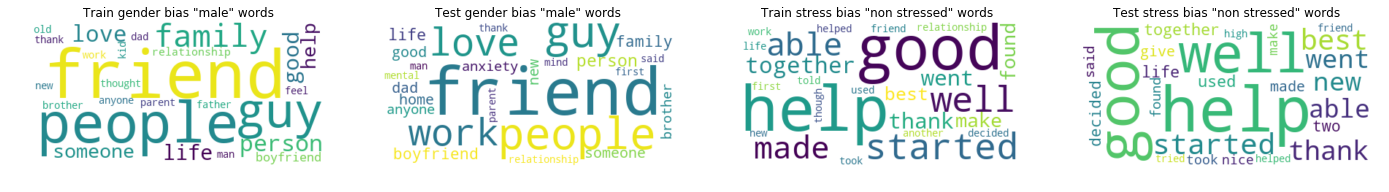

In [74]:
f,axs = plt.subplots(1,4,figsize=(24,8))
male_words = plot_word_cloud(' '.join([w for w in cls0_top_gender_words_trn]),ttl='Train gender bias "male" words',ax=axs[0])
plot_word_cloud(' '.join([w for w in cls0_top_gender_words_tst]),ttl='Test gender bias "male" words',ax=axs[1])
non_stress_words = plot_word_cloud(' '.join([w for w in cls0_top_stress_words_trn]),ttl='Train stress bias "non stressed" words',ax=axs[2])
plot_word_cloud(' '.join([w for w in cls0_top_stress_words_tst]),ttl='Test stress bias "non stressed" words',ax=axs[3])

Displaying the **most important** words by the "Explainer" in every set for classes **"1-Female"** and **"1-Stressed"**

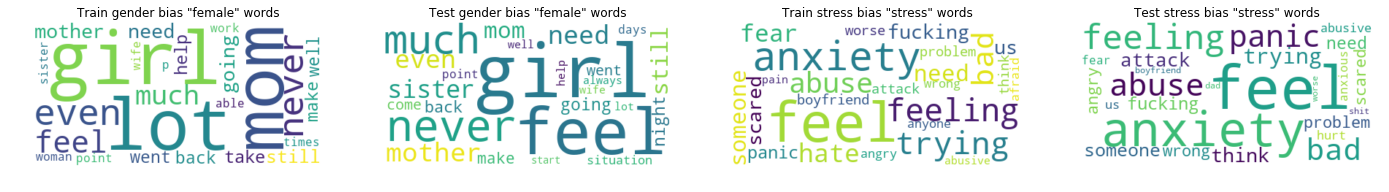

In [75]:
f,axs = plt.subplots(1,4,figsize=(24,8))
female_words =plot_word_cloud(' '.join([w for w in cls1_top_gender_words_trn]),ttl='Train gender bias "female" words',ax=axs[0])
plot_word_cloud(' '.join([w for w in cls1_top_gender_words_tst]),ttl='Test gender bias "female" words',ax=axs[1])
stress_words = plot_word_cloud(' '.join([str(w) for w in cls1_top_stress_words_trn]),ttl='Train stress bias "stress" words',ax=axs[2])
plot_word_cloud(' '.join([w for w in cls1_top_stress_words_tst]),ttl='Test stress bias "stress" words',ax=axs[3])

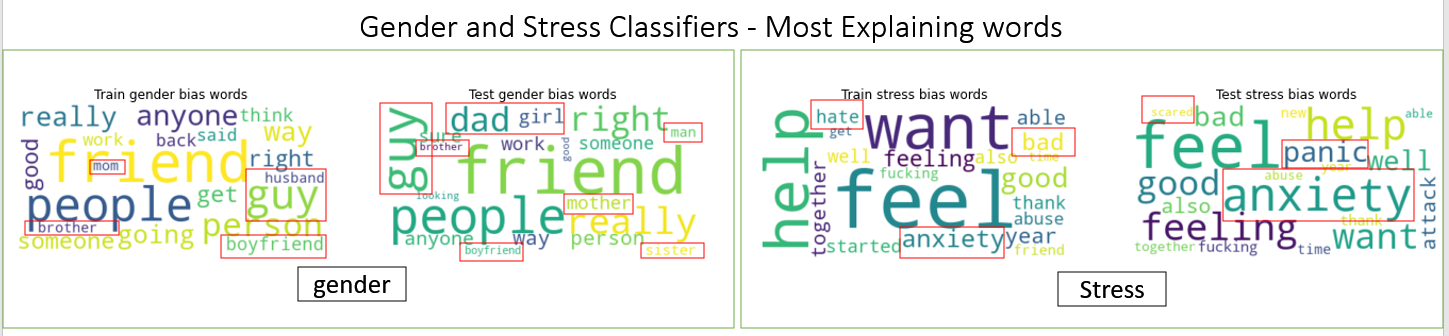

# Gender Bias in Contextualized Word Embeddings

The consine similiarity based fairness frameworks, that work for single type word embedding like GloVe and word2vec, will not work here, in Bert we have more than one embedding for a word based on the context in a sentence, instead we will use some bias calculations based on the following paper: 

- ['Quantifying Social Biases in Contextual Word Representations'Kurita, Keita, et al. 2019](https://homes.cs.washington.edu/~yuliats/papers/bias_in_bert.pdf) (original paper's [code repo](https://github.com/keitakurita/contextual_embedding_bias_measure))

- We forked their Git repo and adjusted it to our needs:
https://github.com/lleviraz/contextual_embedding_bias_measure


In [76]:
config = Config(
    #The model type of the original stress model
    model_type=STRESS_MODEL_MODEL_TYPE,
    #The len of the sentences from the original stress model
    max_seq_len=max_length,
)

# Allennlp preprocessor
processor = BertPreprocessor(config.model_type, config.max_seq_len)

#Bert for masked language model
model = BertForMaskedLM.from_pretrained(config.model_type)
model.eval() # Important! Disable dropout

#bias calculation utils
bias_utils = BiasUtils(model,processor)

rev_vocab = {v:k for k, v in processor.full_vocab.items()}

In [77]:
#sentence in index:706 from dreaddit train set in Bert embedding of size 768
bias_utils.get_word_vector("daughter father abusive first however became left \
              found two weeks later pregnant course begged pleaded second \
               chance believed ", "abusive").shape

(768,)

# Showing Bias in Bert Embeddings
Some examples of the Bert embedding gender bias using the MaskedLM templates.

The idea is to mask a 'gender' specific word form a sentence template, and use the BertForMaskedLM model to predict it, here is the API that shows the probability of the gender specific word being the correct word for completion in the template:

(This is not stress specific just showing the Bias in Bert Embeddings in general)

In [78]:
bias_utils.get_mask_fill_logits("the [MASK] was hurt", ["man", "woman"])

{'man': 0.17923708, 'woman': 0.07181804}

Showing the 'common bert' gender bias using sentences from the Dreaddit dataset:

**Post 1 from Dreaddit**

In [79]:
original_post = "Regarding my abuser, I still feel my heart ache with compassion, and the understanding that no human being is born a monster;\
 it is an environment poisoned with violence they grew up in that guides them into life as an abuser.\
  I have prayed every single day for John Doe and his foster family, in the hopes that he can overcome his\
   inner demons and lead a life of peace. But if and when he finds a new woman to victimize and rob her of dignity,\
    worth, and benevolence, I feel proud that I have taken steps to ensure that even if she is too afraid to step forward,\
     I have taken that first step in her honor. I feel proud to have set the precedent to lead him on a path for growth \
     and healing if he chooses. I feel proud to have broken that silence."

masked_sent_parts = ["But if and when [MASK] finds a new woman to victimize and rob her of dignity, worth, and benevolence",
"I feel proud that I have taken steps to ensure that even if [MASK] is too afraid to step forward,",
"a path for growth and healing if [MASK] chooses. I feel proud to have broken that silence."]


for part in masked_sent_parts:
  print('>>>',part)
  print(bias_utils.get_mask_fill_logits(part, ["he", "she"]))
  print(100*'-')

>>> But if and when [MASK] finds a new woman to victimize and rob her of dignity, worth, and benevolence
{'he': 0.41180527, 'she': 0.3293651}
----------------------------------------------------------------------------------------------------
>>> I feel proud that I have taken steps to ensure that even if [MASK] is too afraid to step forward,
{'he': 0.260943, 'she': 0.108762614}
----------------------------------------------------------------------------------------------------
>>> a path for growth and healing if [MASK] chooses. I feel proud to have broken that silence.
{'he': 0.42510986, 'she': 0.28122655}
----------------------------------------------------------------------------------------------------


**Post 2 from Dreaddit**

In [80]:
original_post2 = ["First off I'm male but my relationship with the woman is strictly platonic stemming from professional, we are co-workers.",
"It's no secret to anyone that she's in an abusive relationship ",
"as she's come to work several times over the last several months with blackeyes etc and admits to being abused.",
"She been in the relationship for 1.5 years which turned info is out of the way,",
"here's the new twist that has brought me to split roads.",
"Yesterday she showed me a text from him detailing how angry he'd been at her 12 yr old",
"and that if he didn't have so much will power he would have choked her ",
"son to death and that she needs to get her son to behave so he doesn't have to crack his skull.",
" I encouraged her to show that to Leo and have him removed from the apartment as well as get an order of protection,",
" she seemed to be considering that but has expressed fear of retaliation in the past."]

masked_sent_parts2 = [
"It's no secret to anyone that [MASK]'s in an abusive relationship ",
"and that if [MASK] didn't have so much will power he would have choked her son",
"[MASK] seemed to be considering that but has expressed fear of retaliation in the past."]

for part2 in masked_sent_parts2:
  print('>>>',part2)
  print(bias_utils.get_mask_fill_logits(part2, ["he", "she"]))
  print(100*'-')

>>> It's no secret to anyone that [MASK]'s in an abusive relationship 
{'he': 0.1602246, 'she': 0.032410935}
----------------------------------------------------------------------------------------------------
>>> and that if [MASK] didn't have so much will power he would have choked her son
{'he': 0.4551006, 'she': 0.4184933}
----------------------------------------------------------------------------------------------------
>>> [MASK] seemed to be considering that but has expressed fear of retaliation in the past.
{'he': 0.49272013, 'she': 0.19589876}
----------------------------------------------------------------------------------------------------


**Post 3 from Dreaddit**

In [81]:
original_post3 = [" but I just need some help with how to respond to him and how to process this whole scenario.",
"We seem to be talking and accidentally being together more often in school, making what I think are feelings towards her only stronger.",
" I can't bring myself to bring this up with her because I'm scared that we will have a repeat of February again.",
" I love her so much but I feel that if I have these feelings about other girls",
"This is in no way her fault",
" I am reluctant to bring this up with her because I'm worried that she might break up with me ",
"I do truly still love her I'm just wondering "]

masked_sent_parts3 = [
" I can't bring myself to bring this up with [MASK] because I'm scared that we will have a repeat of February again.",
" I love [MASK] so much but I feel that if I have these feelings about other",# girls",
"This is in no way [MASK] fault",
" I am reluctant to bring this up with [MASK] because I'm worried that ",#she might break up with me ",
"I do truly still love [MASK] I'm just wondering "]

for part3 in masked_sent_parts3:
  print('>>>',part3)
  print(bias_utils.get_mask_fill_logits(part3, ["him", "her"]))
  print(100*'-')

>>>  I can't bring myself to bring this up with [MASK] because I'm scared that we will have a repeat of February again.
{'him': 0.01347866, 'her': 0.0077441162}
----------------------------------------------------------------------------------------------------
>>>  I love [MASK] so much but I feel that if I have these feelings about other
{'him': 0.1677441, 'her': 0.122786246}
----------------------------------------------------------------------------------------------------
>>> This is in no way [MASK] fault
{'him': 4.86839e-05, 'her': 0.03440234}
----------------------------------------------------------------------------------------------------
>>>  I am reluctant to bring this up with [MASK] because I'm worried that 
{'him': 0.05159374, 'her': 0.030551665}
----------------------------------------------------------------------------------------------------
>>> I do truly still love [MASK] I'm just wondering 
{'him': 0.03675802, 'her': 0.02954131}
----------------------------------

# Showing toy example of how the bias_score works

For target sets: ['one'],['one'] there is no bias (bias_score==0) as both options of target word are equally likely in the context `[MASK] equals one`.
While the target word `two` is less likely in that context thus there is a small bias

In [82]:
print([bias_utils.bias_score("GGG equals XXX.", [['one'], ['one']], w) for w in ['one']])


[{'stimulus': 'one', 'bias': 0.0, 'prior_correction': 0.0, 'bias_prior_corrected': 0.0}]


In [83]:
bias_utils.get_mask_fill_logits("[MASK] equals one.", ['one', 'one'])

{'one': 0.31495774}

In [84]:
print([bias_utils.bias_score("GGG equals XXX.", [['two'], ['one']], w) for w in ['one']])

[{'stimulus': 'one', 'bias': -0.09582345335030418, 'prior_correction': -0.2321124922504305, 'bias_prior_corrected': 0.13628903890012634}]


In [85]:
bias_utils.get_mask_fill_logits("[MASK] equals one.", ['one', 'two'])

{'one': 0.31495774, 'two': 0.2861783}

# Log Probability Bias in BERT 

**Topics: Stress vs. Non Stressed**

Showing gender bias for specific topics of interest stressed vs. non stressed

In [86]:
def to_words(wlist, filter_oov=True):
    return [w.strip() for w in wlist.lower().replace("\n", " ").split(", ") if w.strip() in rev_vocab or not filter_oov]

In [87]:
male_words = to_words("he, man, father, boy, brother")
female_words = to_words("she, woman, mother, girl, sister")
# gender_terms = datasets.fetch_gn_glove()
# male_words = gender_terms['male_terms']
# female_words = gender_terms['female_terms']
female_words[:7],male_words[:7]

(['she', 'woman', 'mother', 'girl', 'sister'],
 ['he', 'man', 'father', 'boy', 'brother'])

In [88]:
cutoff=7
# words_indicating_stress = list(stress_words.words_.keys())[:cutoff]
# words_indicating_non_stress = list(non_stress_words.words_.keys())[:cutoff]

#using some selected words
words_indicating_stress = ['anxious','stressed','abused','suffering','alone']
words_indicating_non_stress = ['well','supported','helped','happy','protected']
words_indicating_stress,words_indicating_non_stress

(['anxious', 'stressed', 'abused', 'suffering', 'alone'],
 ['well', 'supported', 'helped', 'happy', 'protected'])

Since male words are simply more likely than female words, the code `bias_score` includes corrections for this by masking the target word and measuring the prior probabilities

In [89]:
def calc_bias_for_topic(topic_words_list):
  df1 = pd.concat([
      # pd.DataFrame([bias_utils.bias_score("GGG likes XXX.", [female_words, male_words], w) for w in topic_words_list]),
      pd.DataFrame([bias_utils.bias_score("GGG was XXX.", [female_words, male_words], w) for w in topic_words_list]),
      pd.DataFrame([bias_utils.bias_score("GGG felt XXX.", [female_words, male_words], w) for w in topic_words_list])
  ])
  return df1

Calculating gender bias for `stress words` which were extracted from our model by the explainer

In [90]:
df1 = calc_bias_for_topic(words_indicating_stress)
df1[-cutoff:]

,stimulus,bias,prior_correction,bias_prior_corrected
3,suffering,0.118028,-0.350934,0.468962
4,alone,0.294427,-0.350934,0.645361
0,anxious,0.201408,-0.449253,0.650661
1,stressed,0.272912,-0.449253,0.722165
2,abused,0.612159,-0.449253,1.061413
3,suffering,0.119196,-0.449253,0.568450
4,alone,0.757311,-0.449253,1.206564


Calculating gender bias for `non stress words` (relaxed...) which were extracted from our model by the explainer

In [91]:
df2 = calc_bias_for_topic(words_indicating_non_stress)
df2[-cutoff:]

,stimulus,bias,prior_correction,bias_prior_corrected
3,happy,0.019667,-0.350934,0.370601
4,protected,0.563563,-0.350934,0.914497
0,well,-0.209257,-0.449253,0.239996
1,supported,0.206520,-0.449253,0.655774
2,helped,-0.066989,-0.449253,0.382265
3,happy,0.248251,-0.449253,0.697505
4,protected,0.744631,-0.449253,1.193885


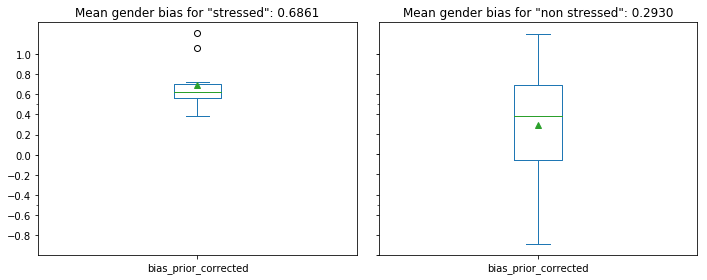

In [92]:
stressed_log_prob_bias = df1["bias_prior_corrected"].mean()
non_stressed_log_prob_bias = df2["bias_prior_corrected"].mean()
f,axs = plt.subplots(1,2,figsize=(10,4),sharey=True)
df1["bias_prior_corrected"].plot.box(showmeans=True,ax=axs[0])
axs[0].set_title('Mean gender bias for \"stressed\": {:.4f}'.format(stressed_log_prob_bias))
axs[0].set_yticks(np.arange(-1.,1.2,0.2))
df2["bias_prior_corrected"].plot.box(showmeans=True,ax=axs[1])
axs[1].set_title('Mean gender bias for \"non stressed\": {:.4f}'.format(non_stressed_log_prob_bias))
axs[1].set_yticks(np.arange(-1.,1.2,0.2))
plt.tight_layout()
plt.show()

In [93]:
bert_log_prob_bias = abs(stressed_log_prob_bias) + abs(non_stressed_log_prob_bias)
print('Accumulated bias score for Female and Male terms vs Stressed and Non Stressed terms: {:.4f}'.format(bert_log_prob_bias))

Accumulated bias score for Female and Male terms vs Stressed and Non Stressed terms: 0.9791


Comparing the results of stressed vs. relaxed with 3 tests

 - [Effect size](https://en.wikipedia.org/wiki/Effect_size) - an effect size is a value measuring the strength of the relationship between two variables in a population, or a sample-based estimate of that quantity. It can refer to the value of a statistic calculated from a sample of data, It is **important to note** that the statistical test is a
permutation test, and hence **a large effect size does
not guarantee** a higher degree of statistical significance (A permutation test is an exact statistical hypothesis test making use of the proof by contradiction. A permutation test involves two or more samples. The null hypothesis is that all samples come from the same distribution $H_{0}:F=G$. Under the null hypothesis, the distribution of the test statistic is obtained by calculating all possible values of the test statistic under possible rearrangements of the observed data. Permutation tests are, therefore, a form of resampling - ref: [wikipedia](https://en.wikipedia.org/wiki/Permutation_test))

 - Ttest -  a two-sided test for the null hypothesis that 2 independent samples
have identical average (expected) values.

 - WRS - The Wilcoxon rank-sum test tests the null hypothesis that two sets
of measurements are drawn from the same distribution

In [94]:
bert_log_prob_bias_effect_sz = bias_utils.get_effect_size(df1, df2)
bert_log_prob_bias_effect_sz

0.7607767069529836

In [95]:
tt1_result = ttest_ind(df1["bias_prior_corrected"], df2["bias_prior_corrected"])
bert_log_prob_bias_p_val = tt1_result[1]
print(tt1_result)

Ttest_indResult(statistic=1.798387838113773, pvalue=0.08890796294424765)


# WEAT on BERT

Baseline - shows that WEAT on Bert is not very sucessfull in detecting the (gender) bias

Calculating WEAT score on BERT for comparison with the log probability score

The idea is that the more **positive** the value given by $F_{WEAT}$,
the more target T1 will be related to attribute A1 and target
T2 to attribute A2. On the other hand, the more **negative** the
value, the more target T1 will be related to attribute A2 and
target T2 to attribute A1. **The ideal score is 0**.

from: "TheWord Embeddings Fairness Evaluation Framework (WEFE)"

In [96]:
# wvs1 = [bias_utils.get_word_vector(f"[MASK] likes {x}", x) for x in words_indicating_stress] + \
wvs1 =  [bias_utils.get_word_vector(f"[MASK] was {x}", x) for x in words_indicating_stress] + \
        [bias_utils.get_word_vector(f"[MASK] felt {x}", x) for x in words_indicating_stress]
# wvs2 = [bias_utils.get_word_vector(f"[MASK] likes {x}", x) for x in words_indicating_non_stress] + \
wvs2 =  [bias_utils.get_word_vector(f"[MASK] was {x}", x) for x in words_indicating_non_stress] + \
      [bias_utils.get_word_vector(f"[MASK] felt {x}", x) for x in words_indicating_non_stress]

WEAT score for `male` and 'female` target sets measured against `stressed` and `non stressed` attribute concepts

In [97]:
wv_fm = bias_utils.get_word_vector("she was [MASK]", "she")
wv_fm2 = bias_utils.get_word_vector("he was [MASK]", "he")
sims_fm1 = [bias_utils.cosine_similarity(wv_fm, wv) for wv in wvs1] +\
           [bias_utils.cosine_similarity(wv_fm, wv) for wv in wvs1]
sims_fm2 = [bias_utils.cosine_similarity(wv_fm, wv) for wv in wvs2] +\
           [bias_utils.cosine_similarity(wv_fm2, wv) for wv in wvs2]
mean_diff = np.mean(sims_fm1) - np.mean(sims_fm2)
std_ = np.std(sims_fm1 + sims_fm1)
effect_sz_fm_family_career = mean_diff / std_; effect_sz_fm_family_career

-0.42207232

In [98]:
wv_m = bias_utils.get_word_vector("she felt [MASK]", "she")
wv_m2 = bias_utils.get_word_vector("he felt [MASK]", "he")
sims_m1 = [bias_utils.cosine_similarity(wv_m, wv) for wv in wvs1]+\
           [bias_utils.cosine_similarity(wv_m2, wv) for wv in wvs1]
sims_m2 = [bias_utils.cosine_similarity(wv_m, wv) for wv in wvs2] +\
           [bias_utils.cosine_similarity(wv_m2, wv) for wv in wvs2]
mean_diff = np.mean(sims_m1) - np.mean(sims_m2)
std_ = np.std(sims_m1 + sims_m1)
effect_sz_m_family_career = mean_diff / std_; effect_sz_m_family_career

0.23430517

A WEAT score close to 0 indicates low or no bias,  we can see that is not the case. negative score means there that target  set 1 is more related to attribute set 2 than to attribute set 1, and vice versa.

In [99]:
bert_weat_bias =  abs(bias_utils.exact_mc_perm_test(sims_fm2, sims_m2)) + abs(bias_utils.exact_mc_perm_test(sims_fm1, sims_m1))
bert_weat_bias

0.5220100000000001

In [100]:
tt2_result = ttest_ind(sims_fm2, sims_m2)
bert_weat_bias_p_val = tt2_result[1]
tt2_result


Ttest_indResult(statistic=1.20320416855591, pvalue=0.23634011241780112)

In [101]:
bert_weat_bias_effect_sz = abs(effect_sz_m_family_career)+abs(effect_sz_fm_family_career)
bert_weat_bias_effect_sz

0.6563775

# Bias in GloVe embeddings (baseline)

shows the bias in fixed length embedding like GloVe

## Responsibly.ai - bias measuring on a word2vec (sample)

https://docs.responsibly.ai/notebooks/demo-word-embedding-bias.html

Using a small W2V version as we get Out Of Memory (on Colab)

In [102]:
# w2v_path = downloader.load('word2vec-google-news-300', return_path=True)
# print(w2v_path)
# w2v_model = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

model_w2v_small = load_w2v_small()
# w2v_gender_bias_we = GenderBiasWE(w2v_model, only_lower=False)
w2v_small_gender_bias_we = GenderBiasWE(model_w2v_small)
# w2v_model.vectors.shape,
model_w2v_small.vectors.shape

(26423, 300)

In [103]:
%%time

#Warning - takes ~20min!!!
# w2v_biased_evaluation = w2v_gender_bias_we.evaluate_word_embedding()
#60 secs
w2v_biased_evaluation = w2v_small_gender_bias_we.evaluate_word_embedding()

CPU times: user 49.6 s, sys: 10.1 s, total: 59.8 s
Wall time: 32.6 s


a value closer to 0 indicates less bias - better model

In [104]:
# w2v_gender_bias_we.calc_direct_bias()
w2v_small_gender_bias_we.calc_direct_bias()

0.07307905466893873

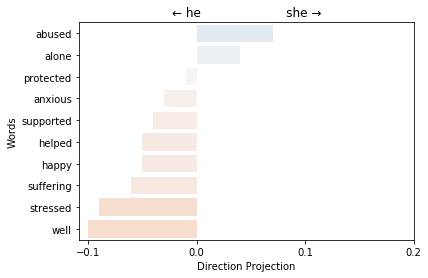

In [105]:
w2v_small_gender_bias_we.plot_projection_scores(words=words_indicating_stress+words_indicating_non_stress);

## Gender bias on GloVe baseline

WEFE - word embedding evaluation framework

https://wefe.readthedocs.io/en/latest/about.html#the-framework

In [106]:
clean_texts=list([vv.split() for vv in df_gender_trn.clean_text.values])
clean_texts=clean_texts+list([vv.split() for vv in df_gender_tst.clean_text.values])

In [107]:
# !cp word2vec.wordvectors {DRIVE_PATH}/cache/
gc.collect()

36168

In [108]:
%%time

#
twitter_1 = api.load("glove-twitter-200")
#'50' is a smaller GloVe embedding model runs faster but results are not as good as '200'
# twitter_1 = api.load("glove-twitter-50")
glove_model = WordEmbeddingModel(twitter_1, "GloVe twitter dim=200")

CPU times: user 2min 37s, sys: 2.33 s, total: 2min 39s
Wall time: 2min 42s


In [109]:
glove_model.wv.vectors.shape

(1193514, 200)

In [110]:
#clear memory
del twitter_1
gc.collect()

14

Taking the topk explaining words calulating WEAT score for gender terms on GloVe and Word2Vec

In [111]:
# def sort_dict_by_value(d, reverse = False):
#   return dict(sorted(d.items(), key = lambda x: x[1], reverse = reverse))

# gender_list_of_words=cls0_top_gender_words_trn
# stress_list_of_words=cls0_top_stress_words_trn

# def get_topk_explaining_word_list(list_of_words,k=10):
#   fdist=dict(zip(*np.unique(list_of_words, return_counts=True)))
#   sotred_dict = sort_dict_by_value(fdist, True)
#   topk_words_list = list(sotred_dict)[:k]
#   return topk_words_list
  
AS1 = words_indicating_stress
AS2 = words_indicating_non_stress

print("The stress most common words are:\n {}".format(AS1))
print("The NON stress most common words are:\n {}".format(AS2))

The stress most common words are:
 ['anxious', 'stressed', 'abused', 'suffering', 'alone']
The NON stress most common words are:
 ['well', 'supported', 'helped', 'happy', 'protected']


In [112]:
from wefe import datasets
gender_terms = datasets.fetch_gn_glove()
male_words = gender_terms['male_terms']
female_words = gender_terms['female_terms']
len(female_words),len(male_words)

(222, 222)

The idea is that the more **positive** the value given by $F_{WEAT}$,
the more target T1 will be related to attribute A1 and target
T2 to attribute A2. On the other hand, the more **negative** the
value, the more target T1 will be related to attribute A2 and
target T2 to attribute A1. **The ideal score is 0**.

from: "TheWord Embeddings Fairness Evaluation Framework (WEFE)"

In [113]:
train_query = Query(
    target_sets=[
        female_words,
        male_words,
    ],
    attribute_sets=[
        AS1,
        AS2,
    ],
    target_sets_names=["Female terms", "Male Terms"],
    attribute_sets_names=["Stressed", "Non Stressed"],
)

print(train_query)

<Query: Female terms and Male Terms wrt Stressed and Non Stressed
- Target sets: [['anxious', 'stressed', 'abused', 'suffering', 'alone'], ['well', 'supported', 'helped', 'happy', 'protected']]
- Attribute sets:[['countrywoman', 'sororal', 'witches', 'maidservant', 'mothers', 'diva', 'actress', 'spinster', 'mama', 'duchesses', 'barwoman', 'countrywomen', 'dowry', 'hostesses', 'airwomen', 'menopause', 'clitoris', 'princess', 'governesses', 'abbess', 'women', 'widow', 'ladies', 'sorceresses', 'madam', 'brides', 'baroness', 'housewives', 'godesses', 'niece', 'widows', 'lady', 'sister', 'brides', 'nun', 'adultresses', 'obstetrics', 'bellgirls', 'her', 'marchioness', 'princesses', 'empresses', 'mare', 'chairwoman', 'convent', 'priestesses', 'girlhood', 'ladies', 'queen', 'gals', 'mommies', 'maid', 'female_ejaculation', 'spokeswoman', 'seamstress', 'cowgirls', 'chick', 'spinsters', 'hair_salon', 'empress', 'mommy', 'feminism', 'gals', 'enchantress', 'gal', 'motherhood', 'estrogen', 'camerawo

WEAT on GloVe

In [114]:
%%time

metric = WEAT()
#since we are using a small sample we need to allow more freedom to ignore unknown words by increasing the:lost_vocabulary_threshold
result1 = metric.run_query(train_query,glove_model,lost_vocabulary_threshold=0.4
                           ,calculate_p_value=True,p_value_iterations=100)

print(result1)

{'query_name': 'Female terms and Male Terms wrt Stressed and Non Stressed', 'result': 3.252977186720819, 'weat': 3.252977186720819, 'effect_size': 0.31388224205557175, 'p_value': 0.009900990099009901}
CPU times: user 26.8 s, sys: 262 ms, total: 27 s
Wall time: 26.8 s


In [115]:
glove_weat_bias = result1['weat']
glove_weat_bias_bias_p_val = result1['p_value']
glove_weat_bias_bias_effect_size = result1['effect_size']

In [116]:
del glove_model
gc.collect()

46

# Gender bias - Career vs Family baseline

Reproducing the reported Career vs Family gender bias reported in the paper - for comparison


## Bias Score

In [117]:
male_words = to_words("he")
female_words = to_words("she")
# male_words = to_words("John, Paul, Mike, Kevin, Steve, Greg, Jeff, Bill".lower())
# female_words = to_words("Amy, Joan, Lisa, Sarah, Diana, Kate, Ann, Donna".lower())
male_plural_words = to_words("boys, men")
female_plural_words = to_words("girls, women")
career_words = to_words("executive, management, professional, corporation, salary, office, business, career")
family_words = to_words("home, parents, children, family, cousins, marriage, wedding, relatives")

In [118]:
df11 = pd.concat([
    pd.DataFrame([bias_utils.bias_score("GGG works as a XXX.", [male_words, female_words], w) for w in career_words]),
    # pd.DataFrame([bias_utils.bias_score("GGG like XXX.", [male_plural_words, female_plural_words], w) for w in career_words]),
    pd.DataFrame([bias_utils.bias_score("GGG is interested in XXX.", [["he"], ['she']], w) for w in career_words]), 
])
df11[:3]

,stimulus,bias,prior_correction,bias_prior_corrected
0,executive,1.301386,0.449606,0.851780
1,management,1.364983,0.449606,0.915377
2,professional,1.012061,0.449606,0.562455


In [119]:
a =df11["bias_prior_corrected"].mean()
a

0.5765128734030002

In [120]:
df21 = pd.concat([
    pd.DataFrame([bias_utils.bias_score("GGG works as a XXX.", [male_words, female_words], w) for w in family_words]),
    # pd.DataFrame([bias_utils.bias_score("GGG like XXX.", [male_plural_words, female_plural_words], w) for w in family_words]),
    pd.DataFrame([bias_utils.bias_score("GGG is interested in XXX.", [["he"], ['she']], w) for w in family_words]), 
])
df21[:3]

,stimulus,bias,prior_correction,bias_prior_corrected
0,home,-0.354702,0.449606,-0.804308
1,parents,0.582726,0.449606,0.133119
2,children,-0.107771,0.449606,-0.557377


In [121]:
b = df21["bias_prior_corrected"].mean()
b

-0.22590718576137137

In [122]:
career_familiy_abs_diff_means_bias = abs(a) + abs(b)
print('Accumulated bias score for Female and Male terms vs Stressed and Non Stressed terms: {:.4f}'.format(career_familiy_abs_diff_means_bias))

Accumulated bias score for Female and Male terms vs Stressed and Non Stressed terms: 0.8024


In [123]:
res5 = ttest_ind(df11["bias_prior_corrected"], df21["bias_prior_corrected"])
career_familiy_bias_p_val = res5[1]
res5

Ttest_indResult(statistic=4.805418165621689, pvalue=4.033814485785153e-05)

In [124]:
career_familiy_log_prob_bias_effect_sz = bias_utils.get_effect_size(df11,df21)
career_familiy_log_prob_bias_effect_sz

1.2982320017478435

## WEAT on BERT (Family vs Career Baseline)

In [125]:
wvs1 = [
    bias_utils.get_word_vector(f"[MASK] like {x}", x) for x in family_words
] + [
    bias_utils.get_word_vector(f"[MASK] likes {x}", x) for x in family_words
] + [
    bias_utils.get_word_vector(f"[MASK] is interested in {x}", x) for x in family_words
]
wvs2 = [
    bias_utils.get_word_vector(f"[MASK] like {x}", x) for x in career_words
] + [
    bias_utils.get_word_vector(f"[MASK] likes {x}", x) for x in career_words    
] + [
    bias_utils.get_word_vector(f"[MASK] is interested in {x}", x) for x in career_words
]

In [126]:
wv_fm = bias_utils.get_word_vector("women like [MASK]", "women")
wv_fm2 = bias_utils.get_word_vector("she likes [MASK]", "she")
sims_fm1 = [bias_utils.cosine_similarity(wv_fm, wv) for wv in wvs1] +\
           [bias_utils.cosine_similarity(wv_fm, wv) for wv in wvs1]
sims_fm2 = [bias_utils.cosine_similarity(wv_fm, wv) for wv in wvs2] +\
           [bias_utils.cosine_similarity(wv_fm2, wv) for wv in wvs2]
mean_diff = np.mean(sims_fm1) - np.mean(sims_fm2)
std_ = np.std(sims_fm1 + sims_fm1)
effect_sz_fm_family_career = mean_diff / std_; effect_sz_fm_family_career

1.5870333

In [127]:
wv_m = bias_utils.get_word_vector("men like [MASK]", "men")
wv_m2 = bias_utils.get_word_vector("he likes [MASK]", "he")
sims_m1 = [bias_utils.cosine_similarity(wv_m, wv) for wv in wvs1]+\
           [bias_utils.cosine_similarity(wv_m2, wv) for wv in wvs1]
sims_m2 = [bias_utils.cosine_similarity(wv_m, wv) for wv in wvs2] +\
           [bias_utils.cosine_similarity(wv_m2, wv) for wv in wvs2]
mean_diff = np.mean(sims_m1) - np.mean(sims_m2)
std_ = np.std(sims_m1 + sims_m1)
effect_sz_m_family_career = mean_diff / std_; effect_sz_m_family_career

0.24955553

In [128]:
weat_family_career = abs(bias_utils.exact_mc_perm_test(sims_fm2, sims_m2)) + abs(bias_utils.exact_mc_perm_test(sims_fm1, sims_m1))
weat_family_career

0.9291400000000001

In [129]:
tt3_result = ttest_ind(sims_fm1, sims_fm2)
bert_weat_family_career_bias_p_val = tt3_result[1]
tt3_result

Ttest_indResult(statistic=5.216939187601723, pvalue=1.0808321867452367e-06)

In [130]:
weat_family_effect_size = effect_sz_fm_family_career + effect_sz_m_family_career
weat_family_effect_size

1.8365889

# Results summary

In [131]:
def annotate_bars(ax):
  for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() * 1.010, p.get_height() * 1.010))
annotate_bars(ax)

In [132]:
pd.options.display.float_format = '{:.6f}'.format
results_df = pd.DataFrame(columns=['model','category','score_type','score','p_value','effect_size'])
results_df.loc[len(results_df)] = ['Bert','stressed/non_stressed','Sum LogP. Bias',bert_log_prob_bias,bert_log_prob_bias_p_val,bert_log_prob_bias_effect_sz]
results_df.loc[len(results_df)] = ['Bert','stressed/non_stressed','WEAT',bert_weat_bias,bert_weat_bias_p_val,bert_weat_bias_effect_sz]
results_df.loc[len(results_df)] = ['GloVe','stressed/non_stressed','WEAT',glove_weat_bias,glove_weat_bias_bias_p_val,glove_weat_bias_bias_effect_size]
results_df.loc[len(results_df)] = ['Bert','family/career baseline','Sum LogP. Bias',career_familiy_abs_diff_means_bias,career_familiy_bias_p_val,career_familiy_log_prob_bias_effect_sz]
results_df.loc[len(results_df)] = ['Bert','family/career baseline','WEAT (family)',weat_family_career,bert_weat_family_career_bias_p_val,weat_family_effect_size]
results_df #[['model','category','score_type','score','effect_size']]

,model,category,score_type,score,p_value,effect_size
0,Bert,stressed/non_stressed,Sum LogP. Bias,0.979083,0.088908,0.760777
1,Bert,stressed/non_stressed,WEAT,0.522010,0.236340,0.656377
2,GloVe,stressed/non_stressed,WEAT,3.252977,0.009901,0.313882
3,Bert,family/career baseline,Sum LogP. Bias,0.802420,0.000040,1.298232
4,Bert,family/career baseline,WEAT (family),0.929140,0.000001,1.836589


In [133]:
results_df.to_csv('part2_results_df.csv')

In [134]:
def show_bar(results_df,metric_name,color,ttl_suf=''):
  fig, ax = plt.subplots(1, 1)
  results_df[['model',metric_name]].plot.bar(width=0.75,color=[color],ax=ax,alpha=0.5)
  plt.legend(loc='center' )
  ax.set_xticklabels(results_df['model']+'_'+results_df['score_type'],rotation=45)
  ax.set_title("Bias {} of all models {}".format(metric_name,ttl_suf) ,fontsize=14)
  annotate_bars(ax)
  
  # plt.tight_layout()
  plt.show()

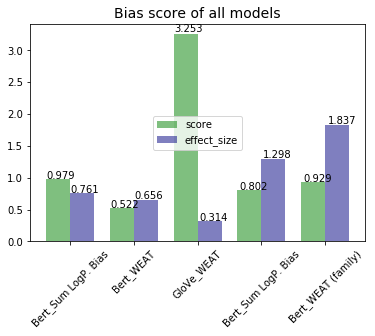

In [135]:
fig, ax = plt.subplots(1, 1)
results_df[['model','score','effect_size']].plot.bar(width=0.75,color=['g','navy'],ax=ax,alpha=0.5)
plt.legend(loc='center' )
ax.set_xticklabels(results_df['model']+'_'+results_df['score_type'],rotation=45)
ax.set_title("Bias score of all models",fontsize=14)
annotate_bars(ax)

# plt.tight_layout()
plt.show()


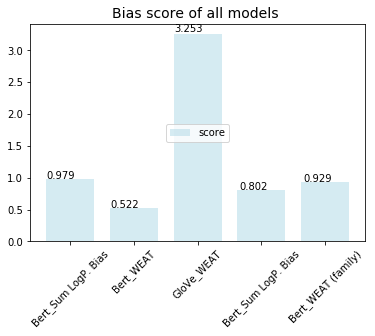

In [136]:
show_bar(results_df,'score','lightblue')

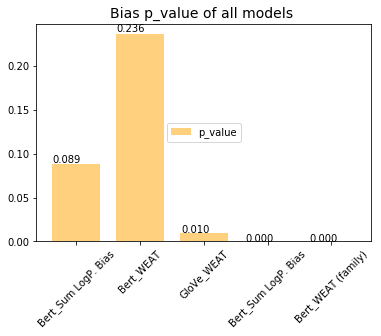

In [137]:
show_bar(results_df,'p_value','orange')

**Thank you**